In [355]:
# Plot the vortex shapes from a single hurricane's from vortex data messages (VDMs)
# Experimental! Do not rely on this.

urls_or_file_paths = [
    # place http urls or file paths here
    #'FRANCINE_AF302_1406A_vdm.txt',
    #'FRANCINE_AF305_1206A_vdm.txt',
    #'https://cyclonicwx.com/data/recon/FRANCINE_NOAA2_1306A_vdm.txt',
    #'https://cyclonicwx.com/data/recon/FRANCINE_AF302_1406A_vdm.txt',
    'REPNT2-KNHC.202409091722.txt',
    'REPNT2-KNHC.202409100111.txt',
    'REPNT2-KNHC.202409100202.txt',
    'REPNT2-KNHC.202409100228.txt',
    'REPNT2-KNHC.202409100341.txt',
    'REPNT2-KNHC.202409100510.txt',
    'REPNT2-KNHC.202409101439.txt',
    'REPNT2-KNHC.202409101524.txt',
    'REPNT2-KNHC.202409101656.txt',
    'REPNT2-KNHC.202409101815.txt',
    'REPNT2-KNHC.202409102341.txt',
    'REPNT2-KNHC.202409110144.txt',
    'REPNT2-KNHC.202409110311.txt',
    'REPNT2-KNHC.202409110516.txt',
    'REPNT2-KNHC.202409110957.txt',
    'REPNT2-KNHC.202409111059.txt',
    'REPNT2-KNHC.202409111303.txt',
    'REPNT2-KNHC.202409111410.txt',
    'REPNT2-KNHC.202409111807.txt',
    'REPNT2-KNHC.202409111914.txt',
    'REPNT2-KNHC.202409112040.txt',
    'REPNT2-KNHC.202409112109.txt',
    'REPNT2-KNHC.202409112159.txt',
    'REPNT2-KNHC.202409112251.txt',
    'REPNT2-KWBC.202409101208.txt',
    'REPNT2-KWBC.202409101343.txt',
    'REPNT2-KWBC.202409101501.txt',
    'REPNT2-KWBC.202409102351.txt',
    'REPNT2-KWBC.202409110040.txt',
    'REPNT2-KWBC.202409110151.txt',
    'REPNT2-KWBC.202409111102.txt',
    'REPNT2-KWBC.202409111224.txt',
    'REPNT2-KWBC.202409111350.txt',
    'REPNT2-KWBC.202409111508.txt',
    # from wyclonic as the last mission is not in the archive yet
    # 'FRANCINE_NOAA2_1306A_vdm.txt',-
    'FRANCINE_NOAA2_1306A_vdm.txt',
    ]

In [382]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeaturej
from datetime import datetime

import numpy as np
import colorspacious as cs

def generate_distinct_colors(n):
    # Generates evenly spaced colors in Lab color space
    colors_lab = np.zeros((n, 3))
    for i in range(n):
        angle = 2 * np.pi * i / n
        lightness = 65
        chroma = 60
        a = chroma * np.cos(angle)
        b = chroma * np.sin(angle)
        colors_lab[i] = [lightness, a, b]

    # Lab to RGB
    colors_rgb = cs.cspace_convert(colors_lab, "CIELab", "sRGB1")
    colors_rgb = np.clip(colors_rgb, 0, 1)

    return colors_rgb


def decode_vdm(url_or_path):
    #print(f"Processing URL: {url}")
    if url_or_path[0:4] == 'http':
        response = requests.get(url_or_path)
        soup = BeautifulSoup(response.text, 'html.parser')
    else:
        with open(url_or_path, 'r') as f:
            data = f.read()
        if data:
            soup = BeautifulSoup(data, 'html.parser')
        else:
            return []
    
    messages = soup.text.split('VORTEX DATA MESSAGE')
    decoded_messages = []
    # guess month
    current_month = datetime.now().month

    for message in messages[1:]:
        lines = message.split('\n')
        atcf_id = lines[0].strip()
        decoded_message = {'atcf_id': atcf_id}
        year = int(atcf_id[-4:])
        for line in lines:
            if line.startswith('A.'):
                decoded_message['date_time'] = datetime.strptime(line.split('Z')[0].split('A.')[-1].strip(), '%d/%H:%M:%S').replace(year=year, month=current_month)
            elif line.startswith('B.'):
                parts = line.split('B.')[-1].strip().split()
                decoded_message['latitude'] = float(parts[0])
                if parts[2] == 'N':
                    decoded_message['latitude'] = abs(decoded_message['latitude'])
                else:
                    decoded_message['latitude'] = -decoded_message['latitude']
                try:
                    decoded_message['longitude'] = float(parts[3])
                except ValueError:
                    print(f"Error converting longitude: {parts[3]}")
                    continue
                if parts[5] == 'W':
                    decoded_message['longitude'] = -decoded_message['longitude']
            elif line.startswith('F.'):
                center_char = line.split('F.')[-1].strip().upper()
                direction = None
                if center_char.startswith('CLOSED'):
                    decoded_message['center_char'] = 'C'
                    decoded_message['direction'] = None
                elif center_char.startswith('OPEN'):
                    decoded_message['center_char'] = 'O'
                    direction = center_char.split(' ')[-1]
                    decoded_message['direction'] = direction
                else:
                    decoded_message['center_char'] = center_char
                    decoded_message['direction'] = None
            elif line.startswith('G.'):
                decoded_message['eye_shape'] = line.split('G.')[-1].strip()
                decoded_message['shape'] = line.split('G.')[-1].strip()
        decoded_messages.append(decoded_message)
    return decoded_messages
    
def plot_eye(decoded_messages, fine_tune_dist=0):
    num_spirals = 2
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    #ax.set_extent([decoded_messages[0]['longitude'] - 2, decoded_messages[0]['longitude'] + 2, decoded_messages[0]['latitude'] - 2, decoded_messages[0]['latitude'] + 2])

    for message in decoded_messages:
        message['nm_to_degree'] = 1 / (60 * np.cos(np.radians(message['latitude'])))

    
    avg_longitude = np.mean([message['longitude'] for message in decoded_messages])
    avg_latitude = np.mean([message['latitude'] for message in decoded_messages])

    min_longitude = np.min([message['longitude'] for message in decoded_messages]) - 1
    max_longitude = np.max([message['longitude'] for message in decoded_messages]) + 1
    min_latitude = np.min([message['latitude'] for message in decoded_messages]) - 1
    max_latitude = np.max([message['latitude'] for message in decoded_messages]) + 1

    # Calculate the maximum distance from the center to the edge of any shape
    max_distance = max(
        np.sqrt((message['longitude'] - avg_longitude)**2 + (message['latitude'] - avg_latitude)**2) + 
        (message['eye_shape'].startswith('C') and int(message['eye_shape'].split('C')[-1].strip()) * message['nm_to_degree'] or 
         message['eye_shape'].startswith('E') and max(int(message['eye_shape'].split('E')[-1].strip().split('/')[0]), int(message['eye_shape'].split('E')[-1].strip().split('/')[1])) * message['nm_to_degree'])
        for message in decoded_messages
    )
    
    # fine tune as max_distance still isnt calculated perfectly...
    max_distance += fine_tune_dist

    # Set the extent to be 1 degree larger than the maximum distance
    ax.set_extent([avg_longitude - max_distance, avg_longitude + max_distance, avg_latitude - max_distance, avg_latitude + max_distance])
    
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    zorder=0
    ax.gridlines(draw_labels=True, zorder=zorder)
    ax.coastlines()
    #colors = ['red', 'blue', 'green', 'yellow', 'purple', 'pink', 'cyan', 'orange']
    colors = generate_distinct_colors(len(decoded_messages))
    
    atcf_id = decoded_messages[0]['atcf_id']
    ax.set_title(f"(Unofficial) Vortex Plot of {atcf_id} using VDMs from NOAA")

    decoded_messages.sort(key=lambda x: x['date_time'])
    for i, message in enumerate(decoded_messages):
        nm_to_degree = message['nm_to_degree']
        if message['center_char'] == 'O' and message['direction']:
            open_str = f", Open {message['direction']}"
            direction = message['direction']
            theta_start, theta_end = get_theta_range(direction)
        else:
            open_str = ''
            theta_start, theta_end = 0, 2*np.pi
        
        if message['eye_shape'].startswith('C'):
            # circle or concentric
            radius_nm = int(message['eye_shape'].split('C')[-1].strip()) / 2.0
            radius_deg = radius_nm * nm_to_degree

            if message['eye_shape'].startswith('CO'):
                concentric = True
            else:
                concentric = False
                
            if concentric:
                inner_outer = message['eye_shape'].split('O')[1].strip()
                inner_nm_str, outer_nm_str = inner_outer.split('-')
                inner_deg = int(inner_nm_str) * nm_to_degree
                outer_deg = int(outer_nm_str) * nm_to_degree
                concentric_str = ', Concentric'
                for on_outer, radius_deg in enumerate([inner_deg, outer_deg]):
                    if message['center_char'] == 'O':
                        direction = message['direction']
                        theta_start, theta_end = get_theta_range(direction)
                        theta = np.linspace(theta_start, theta_end, 100)
                        x = message['longitude'] + radius_deg * np.cos(theta)
                        y = message['latitude'] + radius_deg * np.sin(theta)
                        zorder += 1
                        ax.plot(x, y, color=colors[i], linestyle=(0, (2, 2)), transform=ccrs.PlateCarree(), zorder=zorder)

                        # Plot solid line for remainder
                        theta_start, theta_end = theta_end, theta_start + 2*np.pi
                        theta = np.linspace(theta_start, theta_end, 100)
                        x = message['longitude'] + radius_deg * np.cos(theta)
                        y = message['latitude'] + radius_deg * np.sin(theta)
                        
                        theta = np.linspace(theta_start, theta_end, 100)
                        theta_start, theta_end = get_theta_range(direction)
                        # Find the indices for the dotted line segment
                        idx_start = np.argmin(np.abs(theta - theta_start))
                        idx_end = np.argmin(np.abs(theta - theta_end))

                        # Prevent overlaps
                        points_a = list(zip(x[:idx_start], y[:idx_start]))
                        points_b = list(zip(x[idx_end:], y[idx_end:]))

                        points = points_b + points_a

                        # Check for overlap between start and end of the list
                        overlap_idx = []
                        for j in range(len(points)//2):
                            if points[j] in points[len(points)//2:]:
                                overlap_idx.append(j)

                        # Remove the overlapping points
                        x_solid = [x for i, (x, y) in enumerate(points) if i not in overlap_idx]
                        y_solid = [y for i, (x, y) in enumerate(points) if i not in overlap_idx]

                        if on_outer:
                            zorder += 1
                            ax.plot(x_solid, y_solid, color=colors[i], linestyle='-', transform=ccrs.PlateCarree(), label=f"{message['date_time'].strftime('%d/ %H:%M')}{concentric_str}{open_str}", zorder=zorder)
                            zorder += 1
                            ax.plot(message['longitude'], message['latitude'], marker='o', color=colors[i], zorder=zorder)
                        else:
                            zorder += 1
                            ax.plot(x, y, color=colors[i], linestyle='-', transform=ccrs.PlateCarree(), zorder=zorder)
                    else:
                        if on_outer:
                            zorder += 1
                            circle = mpatches.Circle((message['longitude'], message['latitude']), radius_nm, edgecolor=colors[i], facecolor='none', transform=ccrs.PlateCarree(), label=f"{message['date_time'].strftime('%d/ %H:%M')}{concentric_str}{open_str}", zorder=zorder)
                            ax.add_patch(circle)
                            zorder += 1
                            ax.plot(message['longitude'], message['latitude'], marker='o', color=colors[i], zorder=zorder)
                        else:
                            zorder += 1
                            circle = mpatches.Circle((message['longitude'], message['latitude']), radius_nm, edgecolor=colors[i], facecolor='none', transform=ccrs.PlateCarree(), zorder=zorder)
                            ax.add_patch(circle)
            else:
                #circle
                if message['center_char'] == 'O':
                    direction = message['direction']
                    theta_start, theta_end = get_theta_range(direction)
                    theta = np.linspace(theta_start, theta_end, 100)
                    x = message['longitude'] + radius_deg * np.cos(theta)
                    y = message['latitude'] + radius_deg * np.sin(theta)
                    zorder += 1
                    ax.plot(x, y, color=colors[i], linestyle=(0, (2, 2)), transform=ccrs.PlateCarree(), zorder=zorder)

                    # Plot solid line for remainder
                    theta_start, theta_end = theta_end, theta_start + 2*np.pi
                    theta = np.linspace(theta_start, theta_end, 100)
                    x = message['longitude'] + radius_deg * np.cos(theta)
                    y = message['latitude'] + radius_deg * np.sin(theta)

                    zorder += 1

                    theta = np.linspace(theta_start, theta_end, 100)
                    theta_start, theta_end = get_theta_range(direction)
                    # Find the indices for the dotted line segment
                    idx_start = np.argmin(np.abs(theta - theta_start))
                    idx_end = np.argmin(np.abs(theta - theta_end))

                    # Prevent overlaps
                    points_a = list(zip(x[:idx_start], y[:idx_start]))
                    points_b = list(zip(x[idx_end:], y[idx_end:]))
                    points = points_b + points_a

                    # Check for overlap between start and end of the list
                    overlap_idx = []
                    for j in range(len(points)//2):
                        if points[j] in points[len(points)//2:]:
                            overlap_idx.append(j)

                    # Remove the overlapping points
                    x_solid = [x for i, (x, y) in enumerate(points) if i not in overlap_idx]
                    y_solid = [y for i, (x, y) in enumerate(points) if i not in overlap_idx]
                    
                    ax.plot(x_solid, y_solid, color=colors[i], linestyle='-', transform=ccrs.PlateCarree(), label=f"{message['date_time'].strftime('%d/ %H:%M')}{open_str}", zorder=zorder)
                    zorder += 1
                    ax.plot(message['longitude'], message['latitude'], marker='o', color=colors[i], zorder=zorder)
                else:
                    zorder += 1
                    circle = mpatches.Circle((message['longitude'], message['latitude']), radius_nm, edgecolor=colors[i], facecolor='none', transform=ccrs.PlateCarree(), label=f"{message['date_time'].strftime('%d/ %H:%M')}{open_str}", zorder=zorder)
                    ax.add_patch(circle)
                    zorder += 1
                    ax.plot(message['longitude'], message['latitude'], marker='o', color=colors[i], zorder=zorder)

        elif message['eye_shape'].startswith('E'):
            orientation, axis1, axis2 = message['eye_shape'].split('E')[-1].strip().split('/')
            orientation, axis1, axis2 = int(orientation), int(axis1), int(axis2)
            # radius in deg
            axis1_deg = axis1 * nm_to_degree / 2.0
            axis2_deg = axis2 * nm_to_degree / 2.0
            
            if message['center_char'] == 'O':

                direction = message['direction']
                theta_start, theta_end = get_theta_range(direction)

                # Create the ellipse path
                theta = np.linspace(0, 2*np.pi, 100)
                x = message['longitude'] + axis1_deg * np.cos(theta) * np.cos(np.radians(orientation)) - axis2_deg * np.sin(theta) * np.sin(np.radians(orientation))
                y = message['latitude'] + axis1_deg * np.cos(theta) * np.sin(np.radians(orientation)) + axis2_deg * np.sin(theta) * np.cos(np.radians(orientation))

                # Find the indices for the dotted line segment
                idx_start = np.argmin(np.abs(theta - theta_start))
                idx_end = np.argmin(np.abs(theta - theta_end))

                # Plot the ellipse with a dotted linestyle for the specified segment
                zorder += 1
                ax.plot(x[idx_start:idx_end], y[idx_start:idx_end], color=colors[i], linestyle=(0, (2, 2)), transform=ccrs.PlateCarree(), zorder=zorder)

                # Plot the ellipse with a solid linestyle for the remaining segments, excluding the endpoints
                zorder += 1

                # Prevent overlaps
                points_a = list(zip(x[:idx_start], y[:idx_start]))
                points_b = list(zip(x[idx_end:], y[idx_end:]))

                points = points_b + points_a

                # Check for overlap between start and end of the list
                overlap_idx = []
                for j in range(len(points)//2):
                    if points[j] in points[len(points)//2:]:
                        overlap_idx.append(j)
                
                # Remove the overlapping points
                x_solid = [x for i, (x, y) in enumerate(points) if i not in overlap_idx]
                y_solid = [y for i, (x, y) in enumerate(points) if i not in overlap_idx]

                # Plot the solid line
                ax.plot(x_solid, y_solid, color=colors[i], linestyle='-', transform=ccrs.PlateCarree(), label=f"{message['date_time'].strftime('%d/ %H:%M')}{open_str}", zorder=zorder)

                zorder += 1
                ax.plot(message['longitude'], message['latitude'], marker='o', color=colors[i], zorder=zorder)
            else:
                # ellipse takes diameter
                zorder += 1
                ellipse = mpatches.Ellipse((message['longitude'], message['latitude']), axis1_deg*2, axis2_deg*2, angle=orientation, edgecolor=colors[i], facecolor='none', transform=ccrs.PlateCarree(), zorder=zorder)
                ax.add_patch(ellipse)
                zorder += 1
                ax.plot(message['longitude'], message['latitude'], marker='o', color=colors[i], label=f"{message['date_time'].strftime('%d/ %H:%M')}{open_str}", zorder=zorder)
        elif message['eye_shape'].startswith('S'):
            # Open Spiral
            spiral_str = ', Spiral'
            radius_nm = int(message['eye_shape'].split('S')[-1].strip()) / 2.0
            radius_deg = radius_nm * nm_to_degree
            if message['center_char'] == 'O':

                direction = message['direction']
                open_str = f", Open {message['direction']}"
                theta_start, theta_end = get_theta_range(direction)

                # Normalize theta_start and theta_end to the range [0, 2π] to handle crossing zero degrees
                theta_start = np.mod(theta_start, 2 * np.pi)
                theta_end = np.mod(theta_end, 2 * np.pi)

                # Number of full spirals (multiple cycles)
                num_cycles = int(np.ceil((num_spirals * 2 * np.pi) / (2 * np.pi)))

                # Generate full theta and r arrays for the spiral
                theta = np.linspace(0, num_spirals * 2 * np.pi, 1000)  # Full range of theta
                r = np.linspace(0, radius_deg, len(theta))  # Radius for each theta value
                x = message['longitude'] + r * np.cos(theta)
                y = message['latitude'] + r * np.sin(theta)

                # Initialize zorder
                zorder += 1

                def is_between_angles(angle, start, end):
                    """
                    Checks if 'angle' lies between 'start' and 'end' angles, intelligently accounting for multiple rotations and wrapping.
                    """
                    # Adjust angle until it's within a comparable range relative to start
                    while angle < start:
                        angle += 2 * np.pi

                    while angle > end:
                        angle -= 2 * np.pi

                    # After adjusting, return True if it's now between start and end
                    return start <= angle <= end


                # Iterate over the theta values and plot segments for each cycle of 2π
                segment_start_idx = 0
                current_is_dotted = False

                current_angle = theta[0]
                cycle_number = int(current_angle // (2 * np.pi))  # Determine current cycle number (multiple of 2π)
                cycle_angle = current_angle - cycle_number * 2 * np.pi  # Angle within the current cycle

                if is_between_angles(cycle_angle, theta_start, theta_end) != current_is_dotted:
                    linestyle = (0, (2, 2)) if current_is_dotted else '-'

                    # Plot the current segment (either solid or dotted)
                    ax.plot(x[segment_start_idx:j], y[segment_start_idx:j], color=colors[i],  # Keep colors[i] inside the larger loop
                            linestyle=linestyle, transform=ccrs.PlateCarree(), zorder=zorder)

                    # Update for the next segment
                    segment_start_idx = j
                    current_is_dotted = not current_is_dotted
                
                for j in range(1, len(theta)):  # Changed to 'j' to loop over theta
                    current_angle = theta[j]
                    cycle_number = int(current_angle // (2 * np.pi))  # Determine current cycle number (multiple of 2π)
                    cycle_angle = current_angle - cycle_number * 2 * np.pi  # Angle within the current cycle

                    # Check if we're in the dotted region for this cycle
                    if is_between_angles(cycle_angle, theta_start, theta_end) != current_is_dotted:
                        linestyle = (0, (2, 2)) if current_is_dotted else '-'

                        # Plot the current segment (either solid or dotted)
                        ax.plot(x[segment_start_idx:j], y[segment_start_idx:j], color=colors[i],  # Keep colors[i] inside the larger loop
                                linestyle=linestyle, transform=ccrs.PlateCarree(), zorder=zorder)

                        # Update for the next segment
                        segment_start_idx = j
                        current_is_dotted = not current_is_dotted

                # Plot the final segment of the spiral
                linestyle = (0, (2, 2)) if current_is_dotted else '-'
                ax.plot(x[segment_start_idx:], y[segment_start_idx:], color=colors[i], linestyle=linestyle, 
                        transform=ccrs.PlateCarree(), zorder=zorder, label=f"{message['date_time'].strftime('%d/ %H:%M')}{spiral_str}{open_str}")

                # Plot the marker at the center of the spiral
                zorder += 1
                ax.plot(message['longitude'], message['latitude'], marker='o', color=colors[i], zorder=zorder)
    
            else:
                # closed spiral
                direction = message['direction']
                open_str = ""
                theta_start, theta_end = get_theta_range(direction)

                # Normalize theta_start and theta_end to the range [0, 2π] if necessary
                theta_start = np.mod(theta_start, 2 * np.pi)
                theta_end = np.mod(theta_end, 2 * np.pi)

                # Number of full spirals (multiple cycles)
                num_cycles = int(np.ceil((num_spirals * 2 * np.pi) / (2 * np.pi)))

                # Generate full theta and r arrays for the spiral
                theta = np.linspace(0, num_spirals * 2 * np.pi, 1000)  # Full range of theta
                r = np.linspace(0, radius_deg, len(theta))  # Radius for each theta value
                x = message['longitude'] + r * np.cos(theta)
                y = message['latitude'] + r * np.sin(theta)

                # Initialize zorder
                zorder += 1

                # Plot the entire spiral as a solid line
                ax.plot(x, y, color=colors[i], linestyle='-', transform=ccrs.PlateCarree(), zorder=zorder, 
                        label=f"{message['date_time'].strftime('%d/ %H:%M')}{spiral_str}{open_str}")

                # Plot the marker at the center of the spiral
                ax.plot(message['longitude'], message['latitude'], marker='o', color=colors[i], zorder=zorder)

    ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1), title='Time (UTC)')

    plt.savefig(f'{atcf_id.lower()}_vortex_plot.png', bbox_inches='tight')
    plt.show()
    
def get_theta_range(direction):
    pi_center = {
        'E': 0,
        'ENE': 0.125,
        'NE': 0.25,
        'NNE': 0.375,
        'N': 0.5,
        'NNW': 0.675,
        'NW': 0.75,
        'WNW': 0.875,
        'W': 1.0,
        'WSW': 1.125,
        'SW': 1.25,
        'SSW': 1.375,
        'S': 1.5,
        'SSE': 1.675,
        'SE': 1.75,
        'ESE': 1.875 
    }
    if direction in pi_center.keys():
        pi_center_mult = pi_center[direction]
        return (pi_center_mult - 0.25) * np.pi, (pi_center_mult + 0.25) * np.pi

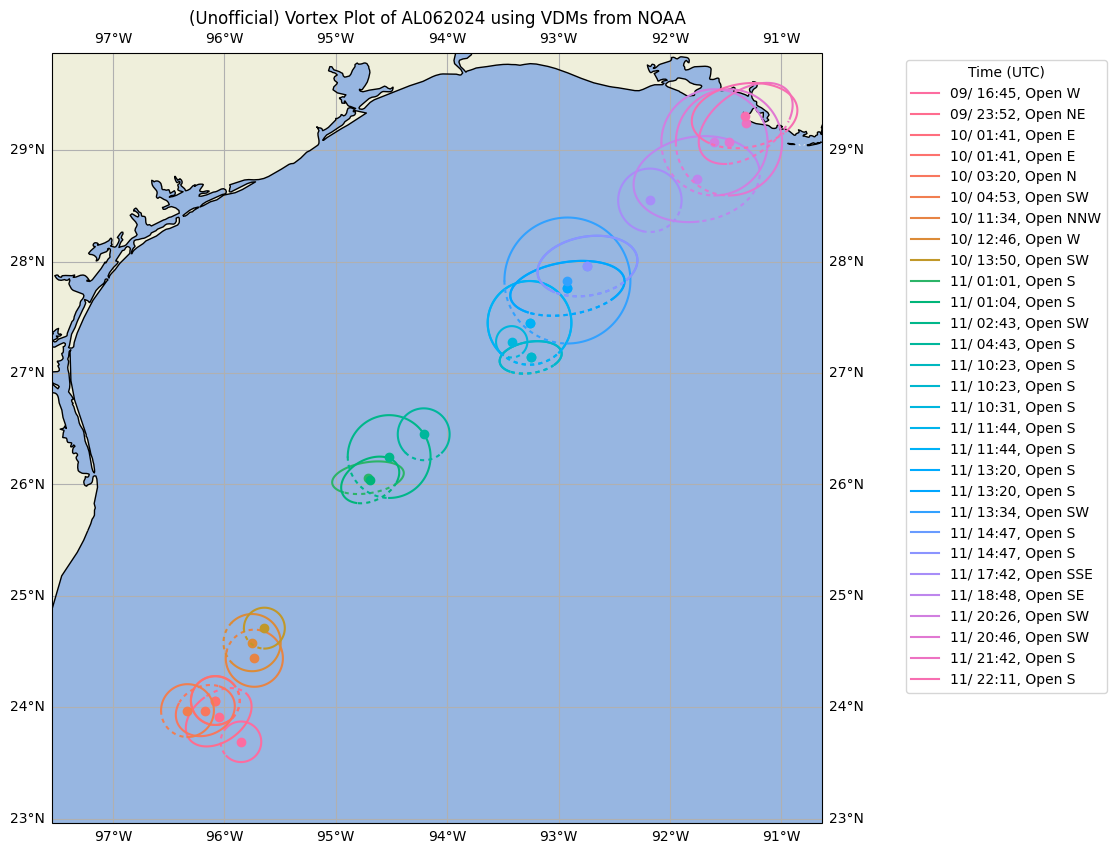

In [383]:
decoded_messages = []
for url_or_file_path in urls_or_file_paths:
    decoded_messages.extend(decode_vdm(url_or_file_path))

plot_eye(decoded_messages, fine_tune_dist=-1.5)